In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import re
from typing import List, Dict, Tuple

import pandas as pd
from scipy.io import wavfile
from pythainlp.tokenize import word_tokenize

from spell_correction import correct_sentence

# ipython
import IPython.display as ipd
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

In [3]:
cv_root: str = "../data/cv-corpus-7.0-2021-07-21"
label_root: str = "labels-aj-ek"

In [4]:
# clean from raw

# train: pd.DataFrame = pd.read_csv(f"{cv_root}/th/train.tsv", delimiter="\t")
# train["set"] = "train"
# dev: pd.DataFrame = pd.read_csv(f"{cv_root}/th/dev.tsv", delimiter="\t")
# dev["set"] = "dev"
# test: pd.DataFrame = pd.read_csv(f"{cv_root}/th/test.tsv", delimiter="\t")
# test["set"] = "test"
# data: pd.DataFrame = pd.read_csv(f"{cv_root}/th/validated.tsv", delimiter="\t")

# command: str = "sox {mp3_path} -t wav -r {sr} -c 1 -b 16 - |"

In [5]:
# clean from aj. Ekapol split

train: pd.DataFrame = pd.read_csv(f"{label_root}/train.tsv", delimiter="\t")
train["set"] = "train"
dev: pd.DataFrame = pd.read_csv(f"{label_root}/dev_unique.tsv", delimiter="\t")
dev["set"] = "dev"
test: pd.DataFrame = pd.read_csv(f"{label_root}/test_unique.tsv", delimiter="\t")
test["set"] = "test"
data: pd.DataFrame = pd.concat([
    train,
    dev,
    test
], axis=0)

command: str = "sox {mp3_path} -t wav -r {sr} -c 1 -b 16 - |"

In [6]:
def get_full_path(cv_root: str, path: str) -> str:
    """Get full path from `path` instance in cv data"""
    f_path: str = f"{cv_root}/th/clips/{path}"
    if not os.path.exists(f_path):
        raise FileNotFoundError(f"File `{f_path}` does not exists")
    return f_path


def get_char(texts: List[str]) -> List[str]:
    """Get unique char from list of documents"""
    return sorted(set([char for sent in texts for char in sent]))


def get_audio_len(audio_path: str) -> float:
    """Get audio duration in second"""
    sr, wav = wavfile.read(audio_path.replace("mp3", "wav").replace("clips", "wav"))
    return len(wav) / sr
#     audio: AudioSegment = AudioSegment.from_mp3(audio_path)
#     return len(audio) / 1000  # pydub duration works in ms


def sec_to_hour(second: int) -> str:
    """Convert second to XXH:YYm:ZZs format"""
    minute, second = divmod(second, 60)
    hour, minute = divmod(minute, 60)
    return f"{int(hour)}H:{int(minute)}m:{second:.2f}s"

In [7]:
# Rules mapping obtained from exploring data
mapping_char: Dict[str, str] = {
    r"!": " ",
    r'"': " ",
    r"'": " ",
    r",": " ",
    r"-": " ",
    r"\.{2,}": " ",
    r"\.$": "",  # full stop at end of sentence
    r"([ก-์])\.([ก-์])": r"\1. \2",  # บจก.XXX -> บจก. XXX
    r":": " ",
    r";": " ",
    r"\?": " ",
    r"‘": " ", 
    r"’": " ",
    r"“": " ", 
    r"”": " ",
    r"~": " ",
    r"—": " ",
    r"\.": " ",
    r"แล้วววว": "แล้ว",
    r"เส้นยาแเงผ่าแปด": "เส้นยาแดงผ่าแปด",
    r"ปากกกา": "ปากกา",
}

# text that needs to be fixed
change_text: Dict[str, str] = {
    "common_voice_th_26103939.mp3": "บริษัทจำกัดดาบเพ็ชร์",
    "common_voice_th_27269555.mp3": "ศุนย์การค้า เจ พี ไรวา",
    "common_voice_th_26429486.mp3": "โศรดาพลัดถิ่น ชอุ่ม ปัญจพรรค์",
    "common_voice_th_25668677.mp3": "มิสเตอร์ ลินคอล์น",
    "common_voice_th_25677501.mp3": "โอ้พระเจ้าพวกเขาฆ่า เคนนี่",
    "common_voice_th_25696778.mp3": "ฉันสงสัยว่า ซี เซคชั่น จะได้รับความนิยมมากกว่าการเกิดตามธรรมชาติในวันหนึ่ง",
    "common_voice_th_25728649.mp3": "เนื่องจากการขาดโปรแกรมความผิดพลาด โจฮันน่า จึงตัดสินใจขายการหาประโยชน์ในตลาดมืด",
    "common_voice_th_25700969.mp3": "บรูค วิจารณ์ตัวเองเพราะรอยยิ้ม",
    "common_voice_th_23897115.mp3": "กลุ่มอาการ แอสเพอร์เจอร์ เป็นรูปแบบของออทิสติก",
    "common_voice_th_25705973.mp3": "การเปิดใช้งาน ซอฟต์แม็ก นั้นมีราคาแพงมากเพื่อใช้ในการคำนวณ",
    "common_voice_th_24149507.mp3": "แอสโทเทริฟ ถูกใช้ปูพื้นในสนามเด็กเล่นกลางแจ้ง",
    "common_voice_th_25665768.mp3": "เฟสบุ๊ก รวบรวมข้อมูลเกี่ยวกับผู้ที่ไม่ได้เป็นสมาชิก",
    "common_voice_th_25636404.mp3": "ใครอยู่ ม โปรดพาอ้อมไปกินข้าวที",
    "common_voice_th_25903042.mp3": "ฉันคิดว่ามันพร้อมแล้ว ฉันกล่าว",
    "common_voice_th_26701409.mp3": "จอมพล ป มีแนวคิดว่าราษฎรจะรักชาติของตนมิได้",
    "common_voice_th_26147573.mp3": "จอมพล ป พิบูลสงคราม",
    "common_voice_th_25900743.mp3": "ไม่ใช่เพื่อคุณ กัซซี่กล่าว",
    "common_voice_th_25682485.mp3": "ขอขอบคุณ จะตรวจสอบอย่างแน่นอน",
    "common_voice_th_25885519.mp3": "ไม่ใช่อะไรสลักสำคัญ ทหารตอบกลับ",
    "common_voice_th_25899784.mp3": "ไม่ใช่อย่างน้อยที่สุด เขากล่าว",
    "common_voice_th_25704992.mp3": "การวินิจฉัยโรคจำเป็นต้องทำอย่างละเอียดและรอบคอบ", # การวินิจฉัยโรคจําเป็นต้องทําอย่างละเอียดและรอบคอบ
    "common_voice_th_25628971.mp3": "เขากำลังทำงานอยู่",  # "เขากำลังทํางานอยู่"
}

# sentence to skip
skip_sentence: Dict[str, str] = {
    "common_voice_th_25683553.mp3": "บางครั้งคนอังกฤษก็ใช้คำว่า whilst แม้ว่ามันจะดูเก่าไปแล้วก็ตาม",
    "common_voice_th_25682645.mp3": "ฉันใช้Flickr ในการเก็บภาพถ่ายออนไลน์ที่สำคัญของฉันเป็นส่วนใหญ่",
    "common_voice_th_25673002.mp3": "Fury X เป็นการ์ดกราฟิกที่ทรงพลังมาก",
    "common_voice_th_25695730.mp3": "Brexiteers เป็นชื่อเล่นที่มอบให้กับผู้ที่สนับสนุนการลงประชามติของ Brexit"
}

skip_rules: List[str] = [
    r"[a-zA-Z]",
]

## Audio EDA

In [31]:
audios: List[str] = data["path"].map(lambda path: get_full_path(cv_root=cv_root, path=path)).tolist()
audios_len: List[float] = [get_audio_len(f) for f in tqdm(audios)]

  0%|          | 0/92635 [00:00<?, ?it/s]

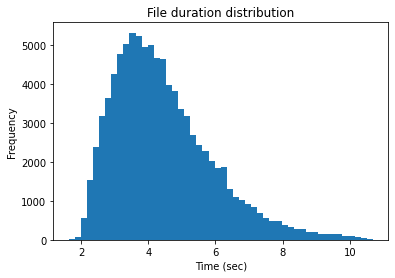

Total: 114H:19m:26.84s
Mean: 4.44
Std.: 1.48
Max: 10.69
Min: 1.62


In [32]:
plt.hist(audios_len, bins=50)
plt.xlabel("Time (sec)")
plt.ylabel("Frequency")
plt.title("File duration distribution")
plt.show()

print(f"Total: {sec_to_hour(np.sum(audios_len))}")
print(f"Mean: {np.mean(audios_len):.2f}")
print(f"Std.: {np.std(audios_len):.2f}")
print(f"Max: {np.max(audios_len):.2f}")
print(f"Min: {np.min(audios_len):.2f}")

## Transcription EDA

In [30]:
texts: pd.DataFrame = data[["path", "sentence"]]
texts["path"] = texts["path"].map(lambda x: get_full_path(cv_root, x))
texts: List[Tuple[str, str]] = texts.values.tolist()
# texts = [correct_sentence(text) for text in tqdm(texts)]

In [31]:
_ = [print(f"`{c}`, ", end="") for c in get_char([x[-1] for x in texts])]

` `, `!`, `"`, `'`, `,`, `-`, `.`, `:`, `;`, `?`, `A`, `B`, `C`, `F`, `J`, `K`, `L`, `M`, `X`, `a`, `b`, `c`, `e`, `f`, `g`, `h`, `i`, `k`, `l`, `m`, `n`, `o`, `p`, `r`, `s`, `t`, `u`, `w`, `x`, `y`, `~`, `ก`, `ข`, `ฃ`, `ค`, `ฆ`, `ง`, `จ`, `ฉ`, `ช`, `ซ`, `ฌ`, `ญ`, `ฎ`, `ฏ`, `ฐ`, `ฑ`, `ฒ`, `ณ`, `ด`, `ต`, `ถ`, `ท`, `ธ`, `น`, `บ`, `ป`, `ผ`, `ฝ`, `พ`, `ฟ`, `ภ`, `ม`, `ย`, `ร`, `ฤ`, `ล`, `ว`, `ศ`, `ษ`, `ส`, `ห`, `ฬ`, `อ`, `ฮ`, `ฯ`, `ะ`, `ั`, `า`, `ำ`, `ิ`, `ี`, `ึ`, `ื`, `ุ`, `ู`, `เ`, `แ`, `โ`, `ใ`, `ไ`, `ๅ`, `ๆ`, `็`, `่`, `้`, `๊`, `๋`, `์`, `ํ`, `—`, `‘`, `’`, `“`, `”`, 

In [38]:
nxt_btn = widgets.Button(description="Next")
back_btn = widgets.Button(description="Back")
output = widgets.Output()

pattern = r"ํ"
idx = 0

def on_nxt_clicked(b):
    global idx
    is_match = False
    terminate = False
    while not is_match:
        if idx == len(texts) - 1:
            is_match = True
            terminate = True
        f_path, sent = texts[idx]
        matches = re.finditer(pattern, sent)
        n_matches: int = sum([1 for _ in matches])
        if n_matches > 0:
            is_match = True
        idx += 1
    with output:
        if terminate:
            ipd.clear_output()
            print("End of corpus. Resetting...")
            idx = 0
        else:
            ipd.clear_output()
            print(f_path)
            print(f"{sent}")
            !afplay $f_path
            ipd.display(ipd.Audio(f_path))

def on_back_clicked(b):
    global idx
    is_match = False
    terminate = False
    while not is_match:
        if idx == 0:
            is_match = True
            terminate = True
        f_path, sent = texts[idx]
        matches = re.finditer(pattern, sent)
        n_matches: int = sum([1 for _ in matches])
        if n_matches > 0:
            is_match = True
        idx =- 1
    with output:
        if terminate:
            ipd.clear_output()
            idx = 0
        else:
            ipd.clear_output()
            print(f_path)
            print(f"{sent}")
            !afplay $f_path
            ipd.display(ipd.Audio(f_path))


display(nxt_btn, back_btn, output)

nxt_btn.on_click(on_nxt_clicked)
back_btn.on_click(on_back_clicked)

Button(description='Next', style=ButtonStyle())

Button(description='Back', style=ButtonStyle())

Output()

In [39]:
_ = [print("\t".join([x[0], x[-1]])) for x in texts if re.search(r"ํ", x[-1])]

../data/cv-corpus-7.0-2021-07-21/th/clips/common_voice_th_25704992.mp3	การวินิจฉัยโรคจําเป็นต้องทําอย่างละเอียดและรอบคอบ
../data/cv-corpus-7.0-2021-07-21/th/clips/common_voice_th_25628971.mp3	เขากำลังทํางานอยู่
../data/cv-corpus-7.0-2021-07-21/th/clips/common_voice_th_25664993.mp3	เขากำลังทํางานอยู่
../data/cv-corpus-7.0-2021-07-21/th/clips/common_voice_th_25689572.mp3	เขากำลังทํางานอยู่
../data/cv-corpus-7.0-2021-07-21/th/clips/common_voice_th_25733924.mp3	เขากำลังทํางานอยู่
../data/cv-corpus-7.0-2021-07-21/th/clips/common_voice_th_25689838.mp3	เขากำลังทํางานอยู่
../data/cv-corpus-7.0-2021-07-21/th/clips/common_voice_th_25704096.mp3	การวินิจฉัยโรคจําเป็นต้องทําอย่างละเอียดและรอบคอบ
../data/cv-corpus-7.0-2021-07-21/th/clips/common_voice_th_23670291.mp3	การวินิจฉัยโรคจําเป็นต้องทําอย่างละเอียดและรอบคอบ
../data/cv-corpus-7.0-2021-07-21/th/clips/common_voice_th_25733488.mp3	เขากำลังทํางานอยู่
../data/cv-corpus-7.0-2021-07-21/th/clips/common_voice_th_26429486.mp3	โศรดาพลัดถิ่น - ชอุ่ม ปํญจ

In [83]:
!afplay data/cv-corpus-7.0-2021-07-21/th/clips/common_voice_th_25636404.mp3

## Preprocess Data

In [8]:
def preprocess_text(text: str) -> str:
    """Preprocess text according to `mapping_char`"""
    text = correct_sentence(text)
    for pattern, sub in mapping_char.items():
        text = re.sub(pattern, sub, text)
    text = re.sub(r" +", " ", text)  # merge multiple whitespaces to one
    text = text[1:] if re.search(r"^[ๆะำฯัิ-ูๅ-์]", text) else text
    return text

def is_valid(text: str) -> bool:
    """Validate each utterance"""
    for rule in skip_rules:
        if re.search(rule, text):
            return False
        else:
            return True

In [9]:
texts: pd.DataFrame = data[["path", "sentence", "set"]]
texts["path"] = texts["path"].map(lambda x: get_full_path(cv_root, x))
texts = texts[texts["sentence"].apply(lambda x: is_valid(x))].reset_index(drop=True)
texts["sentence"] = texts["sentence"].map(lambda x: preprocess_text(x))

remove_idx: List[int] = []
for i in tqdm(range(len(texts)), total=len(texts)):
    f_path: str = os.path.basename(texts.loc[i, "path"])
    for name, change in change_text.items():
        if f_path in name:
            print(texts.loc[i, "path"])
            print("\tReplacing", f"`{texts.loc[i, 'sentence']}`...", "with", f"`{change}`...")
            texts.loc[i, "sentence"] = change
            break
    for name in skip_sentence.keys():
        if f_path in name:
            print(texts.loc[i, "path"])
            print(f"\tRemoving `{texts.loc[i, 'sentence']}`...")
            remove_idx.append(i)
            
texts = texts.drop(texts.index[remove_idx])
            
texts["path"] = texts["path"].map(lambda x: x.replace(f"{cv_root}/th/clips/", ""))
texts = texts.reset_index(drop=True)
texts["sentence"] = texts["sentence"].map(lambda x: re.sub(r" +", " ", x).strip())

/Users/chompk/.env/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


Correct ํ + า => ำ
Correct ํ + า => ำ
Correct ํ + า => ำ
Correct ํ + า => ำ
Correct ํ + า => ำ
Correct ํ + า => ำ
Correct ํ + า => ำ
Correct ํ + า => ำ
Correct ํ + า => ำ
Corrected `่` + `ุ` => `ุ` + `่`


  0%|          | 0/92586 [00:00<?, ?it/s]

../data/cv-corpus-7.0-2021-07-21/th/clips/common_voice_th_25704992.mp3
	Replacing `การวินิจฉัยโรคจำเป็นต้องทำอย่างละเอียดและรอบคอบ`... with `การวินิจฉัยโรคจำเป็นต้องทำอย่างละเอียดและรอบคอบ`...
../data/cv-corpus-7.0-2021-07-21/th/clips/common_voice_th_25628971.mp3
	Replacing `เขากำลังทำงานอยู่`... with `เขากำลังทำงานอยู่`...
../data/cv-corpus-7.0-2021-07-21/th/clips/common_voice_th_25636404.mp3
	Replacing `ใครอยู่ม โปรดพาอ้อมไปกินข้าวที`... with `ใครอยู่ ม โปรดพาอ้อมไปกินข้าวที`...
../data/cv-corpus-7.0-2021-07-21/th/clips/common_voice_th_26147573.mp3
	Replacing `จอมพล ป พิบูลสงคราม`... with `จอมพล ป พิบูลสงคราม`...
../data/cv-corpus-7.0-2021-07-21/th/clips/common_voice_th_25682485.mp3
	Replacing `ขอขอบคุณ จะตรวจสอบอย่างแน่นอน`... with `ขอขอบคุณ จะตรวจสอบอย่างแน่นอน`...
../data/cv-corpus-7.0-2021-07-21/th/clips/common_voice_th_25885519.mp3
	Replacing `ไม่ใช่อะไรสลักสำคัญ ทหารตอบกลับ`... with `ไม่ใช่อะไรสลักสำคัญ ทหารตอบกลับ`...
../data/cv-corpus-7.0-2021-07-21/th/clips/common_voice_th_2

In [10]:
_ = [print(f"\"{c}\", ", end="") for c in get_char([x[1] for x in texts.values.tolist()])]

" ", "ก", "ข", "ฃ", "ค", "ฆ", "ง", "จ", "ฉ", "ช", "ซ", "ฌ", "ญ", "ฎ", "ฏ", "ฐ", "ฑ", "ฒ", "ณ", "ด", "ต", "ถ", "ท", "ธ", "น", "บ", "ป", "ผ", "ฝ", "พ", "ฟ", "ภ", "ม", "ย", "ร", "ฤ", "ล", "ว", "ศ", "ษ", "ส", "ห", "ฬ", "อ", "ฮ", "ฯ", "ะ", "ั", "า", "ำ", "ิ", "ี", "ึ", "ื", "ุ", "ู", "เ", "แ", "โ", "ใ", "ไ", "ๅ", "็", "่", "้", "๊", "๋", "์", 

In [11]:
texts[texts["sentence"] == ""]  # no blank sentence

,path,sentence,set


In [53]:
# inspect character contains {2 or more} repeated character
[(txt, list(re.findall(r"(.)\1{2,}", txt))) for txt in texts["sentence"] if re.search(r"(.)\1{2}", txt)]

[('แม่ต้องมีความพร้อมเมื่อออกไปดูแลลูกด้วยตนเองที่บ้าน', ['อ']),
 ('เขาดึงมือออกมาอีกครั้ง', ['อ']),
 ('ระบบบริหารจัดการข้อมูลภาพถ่ายจากโดรน', ['บ']),
 ('ชาส์ล แบบบาร์จ และ อะดา เลิฟเลส ประดิษฐ์เครื่องจักรกลที่ใช้ในการวิเคราะห์',
  ['บ']),
 ('ฉันงงงวย', ['ง']),
 ('เขาหยุด แล้วคว้ามือออกมา เฉียดตัวฉันไปเส้นยาแเงผ่าแปด', ['อ']),
 ('ฉันถามเธอว่าเขาพาพ่อออกมามั้ย', ['อ']),
 ('สิ่งเหล่านี้เป็นเรื่องน่างงงวยและความขัดแย้งที่ฉันไม่สามารถอธิบายได้',
  ['ง']),
 ('แม่ต้องมีความพร้อมเมื่อออกไปดูแลลูกด้วยตนเองที่บ้าน', ['อ']),
 ('ชาส์ล แบบบาร์จ และ อะดา เลิฟเลส ประดิษฐ์เครื่องจักรกลที่ใช้ในการวิเคราะห์',
  ['บ']),
 ('หากคุณถอดเบรกมือออกรถก็มีแนวโน้มที่จะหมุนออกไป', ['อ']),
 ('ฉันอาบน้ำอย่างงง งง', ['ง']),
 ('แบตเตอรี่รถยนต์บางรุ่นต้องการน้ำกลั่นปราศจากไอออน', ['อ']),
 ('แคทลีนหยิบโทรศัพท์มือถือของเธอออกมากจากกระเป๋าเสื้อ', ['อ']),
 ('การเสพข่าวจากสื่อออนไลน์ต้องคิดให้รอบด้าน', ['อ']),
 ('เขาหยุด แล้วคว้ามือออกมา เฉียดตัวฉันไปเส้นยาแเงผ่าแปด', ['อ']),
 ('เขาหยิบดินสอออกมาจากกระเป๋าเสื้อของเขา', ['อ

In [10]:
# def get_set_from_path(path: str) -> str:
#     """Get whether path belongs to which set"""
#     if  path in dev["path"].values.tolist():
#         return "dev"
#     elif path in test["path"].values.tolist():
#         return "test"
#     else:
#         return "train"
    
# texts["set"] = texts["path"].map(lambda x: get_set_from_path(x))

In [21]:
preprocessed_test = texts[texts["set"] == "test"]
preprocessed_dev = texts[texts["set"] == "dev"]
preprocessed_train = texts[texts["set"] == "train"]

In [22]:
# check train utterances that contains sentence in dev/test set
leakage_utt: List[str] = preprocessed_train.merge(preprocessed_dev, on="sentence")["path_x"].values.tolist() + preprocessed_train.merge(preprocessed_test, on="sentence")["path_x"].values.tolist()
len(leakage_utt)

490

In [23]:
preprocessed_train = preprocessed_train[~preprocessed_train["path"].isin(leakage_utt)]  # remove repeated utt

In [10]:
# preprocessed_train: pd.DataFrame = texts[texts["path"].map(lambda x: x not in dev["path"].values.tolist() + test["path"].values.tolist())]
# preprocessed_dev: pd.DataFrame = texts[texts["path"].map(lambda x: x in dev["path"].values.tolist())]
# preprocessed_test: pd.DataFrame = texts[texts["path"].map(lambda x: x in test["path"].values.tolist())]

# preprocessed_train.to_csv("train.csv", index=False)
# preprocessed_dev.to_csv("dev.csv", index=False)
# preprocessed_test.to_csv("test.csv", index=False)

In [43]:
# preprocessed_train: pd.DataFrame = texts[texts["set"] == "train"]
# preprocessed_dev: pd.DataFrame = texts[texts["set"] == "dev"]
# preprocessed_test: pd.DataFrame = texts[texts["set"] == "test"]

In [27]:
preprocessed_train.to_csv("train.tsv", index=False, sep="\t")
preprocessed_dev.to_csv("dev.tsv", index=False, sep="\t")
preprocessed_test.to_csv("test.tsv", index=False, sep="\t")

## Cleaned Data Audio EDA

  0%|          | 0/86586 [00:00<?, ?it/s]

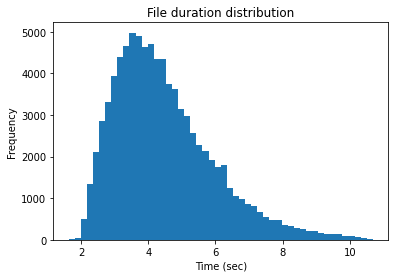

Total: 107H:27m:54.99s
Mean: 4.47
Std.: 1.48
Max: 10.69
Min: 1.62


In [24]:
audios: List[str] = preprocessed_train["path"].map(lambda path: get_full_path(cv_root=cv_root, path=path)).tolist()
audios_len: List[float] = [get_audio_len(f) for f in tqdm(audios)]
plt.hist(audios_len, bins=50)
plt.xlabel("Time (sec)")
plt.ylabel("Frequency")
plt.title("File duration distribution")
plt.show()

print(f"Total: {sec_to_hour(np.sum(audios_len))}")
print(f"Mean: {np.mean(audios_len):.2f}")
print(f"Std.: {np.std(audios_len):.2f}")
print(f"Max: {np.max(audios_len):.2f}")
print(f"Min: {np.min(audios_len):.2f}")

  0%|          | 0/3030 [00:00<?, ?it/s]

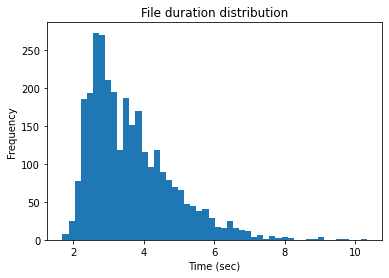

Total: 3H:2m:34.40s
Mean: 3.62
Std.: 1.18
Max: 10.33
Min: 1.69


In [25]:
audios: List[str] = preprocessed_dev["path"].map(lambda path: get_full_path(cv_root=cv_root, path=path)).tolist()
audios_len: List[float] = [get_audio_len(f) for f in tqdm(audios)]
plt.hist(audios_len, bins=50)
plt.xlabel("Time (sec)")
plt.ylabel("Frequency")
plt.title("File duration distribution")
plt.show()

print(f"Total: {sec_to_hour(np.sum(audios_len))}")
print(f"Mean: {np.mean(audios_len):.2f}")
print(f"Std.: {np.std(audios_len):.2f}")
print(f"Max: {np.max(audios_len):.2f}")
print(f"Min: {np.min(audios_len):.2f}")

  0%|          | 0/2502 [00:00<?, ?it/s]

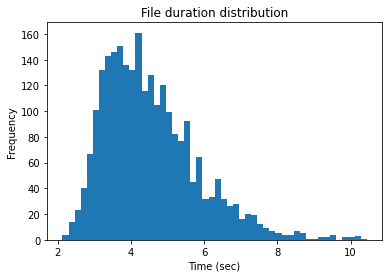

Total: 3H:8m:54.66s
Mean: 4.53
Std.: 1.29
Max: 10.44
Min: 2.12


In [26]:
audios: List[str] = preprocessed_test["path"].map(lambda path: get_full_path(cv_root=cv_root, path=path)).tolist()
audios_len: List[float] = [get_audio_len(f) for f in tqdm(audios)]
plt.hist(audios_len, bins=50)
plt.xlabel("Time (sec)")
plt.ylabel("Frequency")
plt.title("File duration distribution")
plt.show()

print(f"Total: {sec_to_hour(np.sum(audios_len))}")
print(f"Mean: {np.mean(audios_len):.2f}")
print(f"Std.: {np.std(audios_len):.2f}")
print(f"Max: {np.max(audios_len):.2f}")
print(f"Min: {np.min(audios_len):.2f}")